Label share table (%):


,label_name,Train (raw),Test (raw),Train (excl_5),Test (excl_5)
label_id,,,,,
1,neoplasms,21.90,21.92,32.83,32.85
2,digestive system diseases,10.35,10.35,15.51,15.52
3,nervous system diseases,13.33,13.33,19.98,19.98
4,cardiovascular diseases,21.13,21.12,31.68,31.66
5,general pathological conditions,33.28,33.28,0.00,0.00


Label count table (n):


,label_name,Train (raw),Test (raw),Train (excl_5),Test (excl_5)
label_id,,,,,
1,neoplasms,2530,633,2530,633
2,digestive system diseases,1195,299,1195,299
3,nervous system diseases,1540,385,1540,385
4,cardiovascular diseases,2441,610,2441,610
5,general pathological conditions,3844,961,0,0


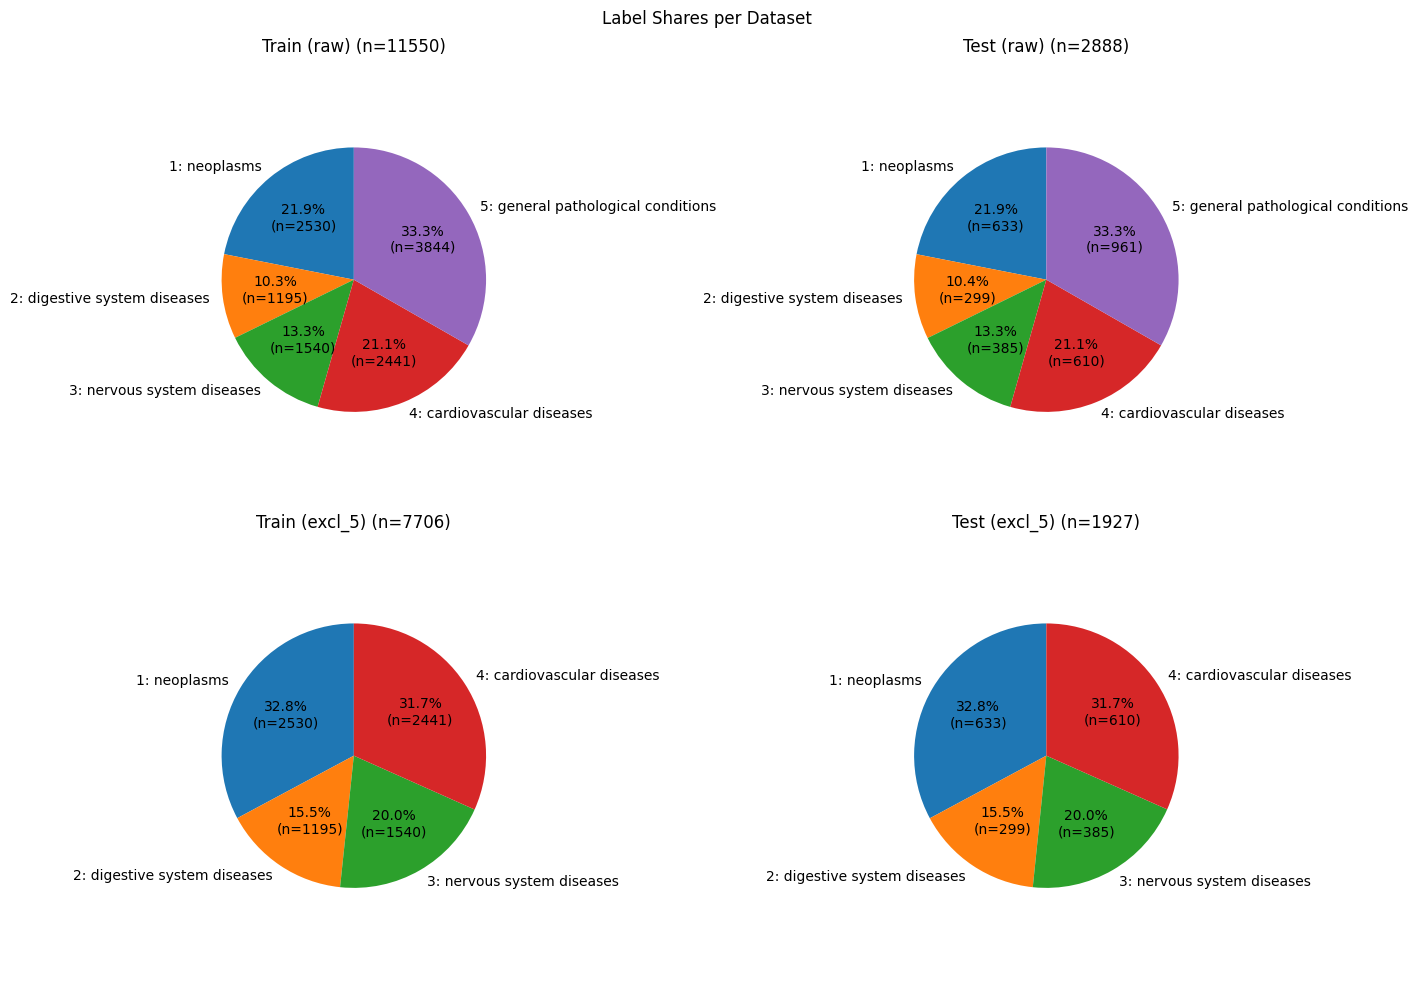

Saved figure -> label_shares_pies.png
Saved tables -> label_shares_percentages.csv, label_counts.csv


In [3]:
# Compare LABEL SHARES across ALL four datasets (raw + excl_5) and plot pie charts
# with totals in titles and per-slice counts (n=...).
# Paste into a Jupyter cell and run.

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---- Paths from your project ----
base_dir = Path("/teamspace/studios/this_studio/data")
datasets = {
    "Train (raw)":      base_dir / "raw" / "medical_tc_train_raw.csv",
    "Test (raw)":       base_dir / "raw" / "medical_tc_test_raw.csv",
    "Train (excl_5)":   base_dir / "data_excluding_5" / "medical_tc_train_raw_excl_5.csv",
    "Test (excl_5)":    base_dir / "data_excluding_5" / "medical_tc_test_raw_excl_5.csv",
}

# Optional label mapping file (if present, ids -> names)
label_map_candidates = [
    base_dir / "raw" / "medical_tc_labels.csv",
    base_dir / "data_excluding_5" / "medical_tc_labels.csv",
]

# ---- Helpers ----
def find_label_column(df):
    for c in ["condition_label", "label", "labels", "target", "y"]:
        if c in df.columns:
            return c
    raise KeyError(
        f"No label column found. Columns present: {list(df.columns)}. "
        "Expected one of: condition_label/label/labels/target/y."
    )

def load_label_map():
    for p in label_map_candidates:
        if p.exists():
            m = pd.read_csv(p)
            for id_col, name_col in [
                ("condition_label", "condition_name"),
                ("label_id", "label_name"),
                ("label", "label_name"),
                ("id", "name"),
            ]:
                if id_col in m.columns and name_col in m.columns:
                    return dict(zip(m[id_col], m[name_col]))
    return None

label_name_map = load_label_map()

def make_autopct(values):
    total = sum(values)
    def _autopct(pct):
        n = int(round(pct*total/100.0))
        return f"{pct:.1f}%\n(n={n})"
    return _autopct

# ---- Compute shares & counts per dataset ----
shares = {}         # percentages
counts_by_ds = {}   # absolute counts
for name, path in datasets.items():
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    df = pd.read_csv(path)
    lbl_col = find_label_column(df)
    counts = df[lbl_col].value_counts().sort_index()
    counts_by_ds[name] = counts
    shares[name] = (counts / counts.sum()) * 100

# ---- Combined tables ----
all_labels = sorted(set().union(*[s.index.tolist() for s in shares.values()]))
percent_table = pd.DataFrame({name: s.reindex(all_labels).fillna(0) for name, s in shares.items()})
count_table   = pd.DataFrame({name: c.reindex(all_labels).fillna(0).astype(int) for name, c in counts_by_ds.items()})
percent_table.index.name = count_table.index.name = "label_id"

if label_name_map:
    percent_table.insert(0, "label_name", [label_name_map.get(i, str(i)) for i in percent_table.index])
    count_table.insert(0, "label_name", [label_name_map.get(i, str(i)) for i in count_table.index])

print("Label share table (%):")
display(percent_table.round(2))
print("Label count table (n):")
display(count_table)

percent_table.round(4).to_csv("label_shares_percentages.csv")
count_table.to_csv("label_counts.csv")

# ---- Plot pies (remove 'label col: ...' text; add n=total in titles; per-slice n in autopct) ----
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, counts) in zip(axes, counts_by_ds.items()):
    ids = counts.index.tolist()
    vals = counts.values
    total_n = vals.sum()

    # labels as "id: name" (no counts here; counts shown by autopct)
    if label_name_map:
        labels = [f"{i}: {label_name_map.get(i, str(i))}" for i in ids]
    else:
        labels = [str(i) for i in ids]

    ax.pie(vals, labels=labels, autopct=make_autopct(vals), startangle=90)
    ax.set_title(f"{name} (n={total_n})")
    ax.axis("equal")

# Hide any unused axes (shouldn't be needed with exactly 4)
for k in range(len(counts_by_ds), len(axes)):
    axes[k].axis("off")

fig.suptitle("Label Shares per Dataset", y=0.98)
fig.tight_layout()
fig.savefig("label_shares_pies.png", bbox_inches="tight", dpi=200)
plt.show()

print("Saved figure -> label_shares_pies.png")
print("Saved tables -> label_shares_percentages.csv, label_counts.csv")


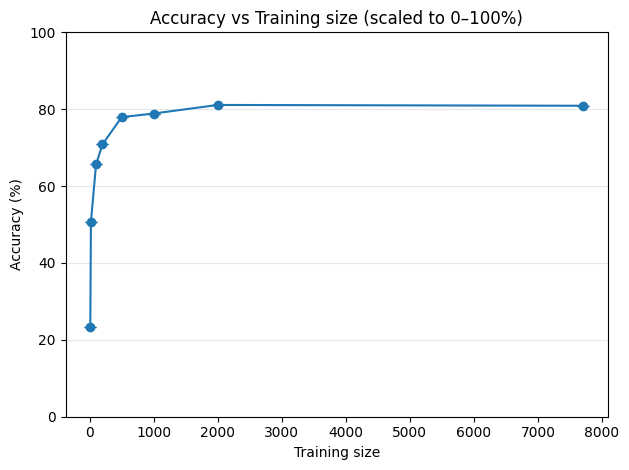

   train_size  acc_mean(%)  acc_std(%)  runs
0          10        23.40         0.0     1
1          20        50.70         0.0     1
2         100        65.65         0.0     1
3         200        70.84         0.0     1
4         500        77.94         0.0     1
5        1000        78.88         0.0     1
6        2000        81.11         0.0     1
7        7706        80.90         0.0     1


In [3]:
# Accuracy vs Training Size — FORCE 0–100% scale on y-axis
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_path = Path("/teamspace/studios/this_studio/Multinomial_Naive_Bayes/reports/experiment_metrics.csv")  # adjust if needed
df = pd.read_csv(csv_path)

def find_col(candidates):
    for c in df.columns:
        if c.lower() in candidates:
            return c
    return None

train_size_col = find_col({"train_size","training_size","n_train","num_train","dataset_size","samples_train","n"})
acc_col        = find_col({"accuracy","acc","val_accuracy","valid_accuracy","validation_accuracy","test_accuracy","eval_accuracy"})
if train_size_col is None or acc_col is None:
    raise KeyError(f"Need training-size and accuracy columns. Got: {list(df.columns)}")

d = df[[train_size_col, acc_col]].copy()
d[train_size_col] = pd.to_numeric(d[train_size_col], errors="coerce")
d[acc_col]        = pd.to_numeric(d[acc_col], errors="coerce")
d = d.dropna()

agg = d.groupby(train_size_col)[acc_col].agg(["mean","std","count"]).reset_index()

# ---- ALWAYS convert to percent and clamp to [0, 100] ----
m = agg["mean"].to_numpy()
s = agg["std"].fillna(0).to_numpy()

# If values look like fractions (<=1), scale up. If they're >100, scale down.
if m.max() <= 1.0:
    y, yerr = m * 100.0, s * 100.0
elif m.max() > 100.0:
    y, yerr = (m / 100.0) * 100.0, (s / 100.0) * 100.0
else:
    y, yerr = m, s

y = np.clip(y, 0, 100)
yerr = np.maximum(0, yerr)

plt.figure()
plt.errorbar(agg[train_size_col], y, yerr=yerr, fmt="-o", capsize=4)
plt.xlabel("Training size")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)             # <- force 0–100%
plt.title("Accuracy vs Training size (scaled to 0–100%)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("accuracy_vs_training_size_0_100.png", dpi=200)
plt.show()

print(agg.rename(columns={train_size_col:"train_size",
                          "mean":"acc_mean(%)","std":"acc_std(%)","count":"runs"})
        .assign(**{"acc_mean(%)":y, "acc_std(%)":yerr}))
